In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import requests
import hvplot.pandas
import geopandas as gpd

# Import API key
from api_keys import geoapify_key

In [2]:
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System (3).csv')
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv')
COW_Country_Codes = pd.read_csv('Resources/COW-country-codes.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')

In [4]:
COW_Country_Codes['StateNme'] = COW_Country_Codes['StateNme'].str.strip().str.lower()
aqua_csv['Area'] = aqua_csv['Area'].str.strip().str.lower()

In [5]:
code_to_country = pd.Series(COW_Country_Codes.StateNme.values, index=COW_Country_Codes.CCode).to_dict()

In [6]:
mie_csv['ccode1'] = mie_csv['ccode1'].map(code_to_country)
mie_csv['ccode2'] = mie_csv['ccode2'].map(code_to_country)
mie_csv.head()

,micnum,eventnum,ccode1,ccode2,stmon,stday,styear,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,united states of america,united kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,austria-hungary,yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,albania,united kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0


In [7]:
mie_csv = mie_csv.rename(columns={'ccode1': 'Country'})
mie_csv = mie_csv.rename(columns={'ccode2': 'Target Country'})
aqua_csv = aqua_csv.rename(columns={'Area': 'Country'})
COW_Country_Codes = COW_Country_Codes.rename(columns={'StateNme':'Country'})
mie_csv = mie_csv.rename(columns={'styear': 'Year'})



In [8]:
conflict_name = pd.Series(micnames.micname.values, index= micnames.micnum).to_dict()

In [9]:
mie_csv['micnum'] = mie_csv['micnum'].map(conflict_name)
mie_csv.head()

,micnum,eventnum,Country,Target Country,stmon,stday,Year,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,Alaska Boundary Dispute (1902),1,united states of america,united kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,Serbian and Austro-Hungarian Fighting over Alb...,1,austria-hungary,yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,British Attempts to Pass the Albanian Corfu Ch...,2,albania,united kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,British Attempts to Pass the Albanian Corfu Ch...,3,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,British Attempts to Pass the Albanian Corfu Ch...,4,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0


In [10]:
merged_df = pd.merge(mie_csv, aqua_csv, on=['Country', 'Year'])
merged_df = merged_df.drop(columns=['sidea1','action','stmon','stday','endmon','endday','endyear','version','VariableGroup','Subgroup','fatalmin1','fatalmin2','IsAggregate','Symbol','IsAggregate'])
merged_df.head()

,micnum,eventnum,Country,Target Country,Year,hostlev,fatalmax1,fatalmax2,Variable,Value,Unit
0,Thai-Cambodian-Vietnamese Border Conflict and ...,35,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
1,Thai-Cambodian-Vietnamese Border Conflict and ...,36,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
2,Thai-Cambodian-Vietnamese Border Conflict and ...,37,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
3,Thai-Cambodian-Vietnamese Border Conflict and ...,38,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
4,Thai-Cambodian-Vietnamese Border Conflict and ...,39,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%


In [11]:
# Use the Pandas copy function to create DataFrame called geo_merged_df that will gather lat/longs for the Country column
geo_merged_df = merged_df.copy()
geo_merged_df.rename(columns={'micnum': 'Conflict'}, inplace=True)
geo_merged_df['Conflict'].fillna(method='bfill', inplace=True)
print(len(geo_merged_df))
geo_merged_df.head()

5560


C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\539837092.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  geo_merged_df['Conflict'].fillna(method='bfill', inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\539837092.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  geo_merged_df['Conflict'].fillna(method='bfill', inplace=True)


,Conflict,eventnum,Country,Target Country,Year,hostlev,fatalmax1,fatalmax2,Variable,Value,Unit
0,Thai-Cambodian-Vietnamese Border Conflict and ...,35,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
1,Thai-Cambodian-Vietnamese Border Conflict and ...,36,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
2,Thai-Cambodian-Vietnamese Border Conflict and ...,37,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
3,Thai-Cambodian-Vietnamese Border Conflict and ...,38,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
4,Thai-Cambodian-Vietnamese Border Conflict and ...,39,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%


In [12]:
filtered_df = geo_merged_df[geo_merged_df['Variable'] == 'SDG 6.4.2. Water Stress']
print(len(filtered_df))
filtered_df.head()

5560


,Conflict,eventnum,Country,Target Country,Year,hostlev,fatalmax1,fatalmax2,Variable,Value,Unit
0,Thai-Cambodian-Vietnamese Border Conflict and ...,35,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
1,Thai-Cambodian-Vietnamese Border Conflict and ...,36,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
2,Thai-Cambodian-Vietnamese Border Conflict and ...,37,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%
3,Thai-Cambodian-Vietnamese Border Conflict and ...,38,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%
4,Thai-Cambodian-Vietnamese Border Conflict and ...,39,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%


In [13]:
import requests
import pandas as pd

# Base URL for the Geoapify Geocoding API
base_url = "https://api.geoapify.com/v1/geocode/search"

# Create dictionaries to store the results of the API requests
cache = {}

# Iterate over the DataFrame
for index, row in filtered_df.iterrows():
    # Extract both country names
    country = row['Country']
    target_country = row['Target Country']

    # Function to get latitude and longitude from Geoapify
    def get_coordinates(country_name):
        # Check if the result is already in the cache
        if country_name in cache:
            return cache[country_name]
        
        # Set parameters for the API request
        params = {
            'text': country_name,
            'apiKey': geoapify_key,
        }
        
        # Make the API request
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Extract latitude and longitude from the response
        try:
            lat = data['features'][0]['properties']['lat']
            lng = data['features'][0]['properties']['lon']
            # Cache the result
            cache[country_name] = (lat, lng)
            return lat, lng
        except (KeyError, IndexError):
            # Handle cases where the API doesn't return a valid result
            print(f"Could not find coordinates for {country_name}")
            return None, None

    # Get coordinates for 'Country'
    lat, lng = get_coordinates(country)
    filtered_df.at[index, 'Country_Lat'] = lat
    filtered_df.at[index, 'Country_Lng'] = lng

    # Get coordinates for 'Target Country'
    lat_targ, lng_targ = get_coordinates(target_country)
    filtered_df.at[index, 'Targ_Country_Lat'] = lat_targ
    filtered_df.at[index, 'Targ_Country_Lng'] = lng_targ

# Display the updated DataFrame
filtered_df.head()


,Conflict,eventnum,Country,Target Country,Year,hostlev,fatalmax1,fatalmax2,Variable,Value,Unit,Country_Lat,Country_Lng,Targ_Country_Lat,Targ_Country_Lng
0,Thai-Cambodian-Vietnamese Border Conflict and ...,35,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%,15.926666,107.965086,14.897192,100.83273
1,Thai-Cambodian-Vietnamese Border Conflict and ...,36,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%,15.926666,107.965086,14.897192,100.83273
2,Thai-Cambodian-Vietnamese Border Conflict and ...,37,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%,15.926666,107.965086,14.897192,100.83273
3,Thai-Cambodian-Vietnamese Border Conflict and ...,38,vietnam,thailand,1980,4,0,0,SDG 6.4.2. Water Stress,8.385011,%,15.926666,107.965086,14.897192,100.83273
4,Thai-Cambodian-Vietnamese Border Conflict and ...,39,vietnam,thailand,1980,3,0,0,SDG 6.4.2. Water Stress,8.385011,%,15.926666,107.965086,14.897192,100.83273


In [14]:
print(len(filtered_df))
print(filtered_df[filtered_df['Target Country'] == 'mexico'])


5560
Empty DataFrame
Columns: [Conflict, eventnum, Country, Target Country, Year, hostlev, fatalmax1, fatalmax2, Variable, Value, Unit, Country_Lat, Country_Lng, Targ_Country_Lat, Targ_Country_Lng]
Index: []


In [15]:
# Fill NaN values with 0 for Value column
filtered_df['Value'].fillna(0, inplace=True)

C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\739932604.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['Value'].fillna(0, inplace=True)


In [16]:
# Calculate the average water stress for each target country
average_water_stress = filtered_df.groupby('Country')['Value'].mean().reset_index()

average_water_stress = average_water_stress.merge(
    filtered_df[['Conflict', 'hostlev', 'Country', 'Target Country', 'Targ_Country_Lat', 'Targ_Country_Lng', 'Country_Lat','Country_Lng']].drop_duplicates(),
    on='Country',
    how='left'
)

# Print the result
average_water_stress.head()
print(len(average_water_stress))

1370


In [18]:
# Group by 'Target Country' and sum 'fatalmax2'
total_fatalities = filtered_df.groupby('Target Country')['fatalmax2'].sum().reset_index()

# Merge with the original DataFrame to include the 'Country' column
total_fatalities = total_fatalities.merge(
    filtered_df[['Conflict', 'hostlev', 'Country','Target Country', 'Targ_Country_Lat', 'Targ_Country_Lng', 'Country_Lat','Country_Lng']].drop_duplicates(),
    on='Target Country',
    how='left'
).drop_duplicates()

# Print the result
total_fatalities.head()
print(len(total_fatalities))

1370


In [19]:
merged1_df = pd.merge(total_fatalities, average_water_stress, on=('Conflict', 'hostlev', 'Country','Target Country','Targ_Country_Lat', 'Targ_Country_Lng', 'Country_Lat','Country_Lng'), how='inner')
print(len(merged1_df))
merged1_df.head()

1370


,Target Country,fatalmax2,Conflict,hostlev,Country,Targ_Country_Lat,Targ_Country_Lng,Country_Lat,Country_Lng,Value
0,afghanistan,6584,Afghan-Pakistani Border Fighting During the So...,2,pakistan,33.768006,66.238514,30.330840,71.247499,107.859551
1,afghanistan,6584,Afghan-Pakistani Border Fighting During the So...,3,pakistan,33.768006,66.238514,30.330840,71.247499,107.859551
2,afghanistan,6584,Afghan-Pakistani Border Fighting During the So...,4,pakistan,33.768006,66.238514,30.330840,71.247499,107.859551
3,afghanistan,6584,United States Intervention in Lebanon (1983),3,iran,33.768006,66.238514,32.647531,54.564352,63.642412
4,afghanistan,6584,Mauritania–Senegal Border War (1989-1990),3,pakistan,33.768006,66.238514,30.330840,71.247499,107.859551


In [20]:
df_cleaned = merged1_df.drop_duplicates(subset=['Targ_Country_Lat', 'Targ_Country_Lng', 'fatalmax2'])
print(len(df_cleaned))
df_cleaned.head()

135


,Target Country,fatalmax2,Conflict,hostlev,Country,Targ_Country_Lat,Targ_Country_Lng,Country_Lat,Country_Lng,Value
0,afghanistan,6584,Afghan-Pakistani Border Fighting During the So...,2,pakistan,33.768006,66.238514,30.330840,71.247499,107.859551
63,albania,2,Hanish Islands Conflict (1995-1996),4,greece,41.000028,19.999962,38.995368,21.987713,17.059229
65,algeria,0,Invasion of Grenada (1983),3,morocco,28.000027,2.999983,31.172821,-7.336248,50.760812
68,angola,678,Israel/Hezbollah and the Lebanon War (1993-2009),4,congo,-11.877577,17.569124,-2.981434,23.822264,0.081253
76,argentina,403,Israeli attack on Iraqi nuclear plant (1981),3,united kingdom,-34.996496,-64.967282,54.702354,-3.276575,20.397881


In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\913829029.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [22]:
# Create copies of the DataFrames
world_normalized = world.copy()

# Normalize case and strip whitespace for merging
world_normalized['name'] = world_normalized['name'].str.strip().str.lower()
df_cleaned['Country'] = df_cleaned['Country'].str.strip().str.lower()
df_cleaned['Target Country'] = df_cleaned['Target Country'].str.strip().str.lower() 

# Replace 'Democratic Republic of the Congo' with 'Congo' in both columns
df_cleaned['Country'] = df_cleaned['Country'].replace('democratic republic of the congo', 'congo')
df_cleaned['Target Country'] = df_cleaned['Target Country'].replace('democratic republic of the congo', 'congo')
world_normalized['name'] = world_normalized['name'].replace("cÃ´te d'ivoire", "Co´te d'Ivoire")
world_normalized['name'] = world_normalized['name'].replace('dem. rep. congo', 'congo')
# Merge DataFrames to include all columns
merged = world_normalized.merge(
    df_cleaned,
    left_on='name',
    right_on='Country',
    how='inner',
    indicator=True
)
# Display merged DataFrame with comparison
merged.head()


C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\950726466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Country'] = df_cleaned['Country'].str.strip().str.lower()
C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\950726466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Target Country'] = df_cleaned['Target Country'].str.strip().str.lower()
C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\950726466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Target Country,fatalmax2,Conflict,hostlev,Country,Targ_Country_Lat,Targ_Country_Lng,Country_Lat,Country_Lng,Value,_merge
0,58005463.0,Africa,tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",burundi,0,Hanish Islands Conflict (1995-1996),3,tanzania,-3.426449,29.932452,-6.524712,35.787844,6.257580,both
1,37589262.0,North America,canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",spain,0,Canadian-EU Fishing Conflict (1995),3,canada,39.326068,-4.837979,61.066692,-107.991707,4.232038,both
2,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",austria,0,Russo-Georgian War over South Ossetia and Abkh...,3,united states of america,47.593970,14.124560,39.783730,-100.445882,29.972104,both
3,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",cuba,25,Chinese-Vietnamese Conflict over the Spratlys ...,3,united states of america,23.013134,-80.832875,39.783730,-100.445882,29.972104,both
4,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",czechoslovakia,0,Able Archer (1983),3,united states of america,48.257918,14.500769,39.783730,-100.445882,29.972104,both


In [23]:
print(len(merged))

137


In [24]:
merged['Log_Value'] = np.log1p(merged['Value'])  
merged.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Target Country,fatalmax2,Conflict,hostlev,Country,Targ_Country_Lat,Targ_Country_Lng,Country_Lat,Country_Lng,Value,_merge,Log_Value
0,58005463.0,Africa,tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",burundi,0,Hanish Islands Conflict (1995-1996),3,tanzania,-3.426449,29.932452,-6.524712,35.787844,6.257580,both,1.982046
1,37589262.0,North America,canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",spain,0,Canadian-EU Fishing Conflict (1995),3,canada,39.326068,-4.837979,61.066692,-107.991707,4.232038,both,1.654801
2,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",austria,0,Russo-Georgian War over South Ossetia and Abkh...,3,united states of america,47.593970,14.124560,39.783730,-100.445882,29.972104,both,3.433087
3,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",cuba,25,Chinese-Vietnamese Conflict over the Spratlys ...,3,united states of america,23.013134,-80.832875,39.783730,-100.445882,29.972104,both,3.433087
4,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",czechoslovakia,0,Able Archer (1983),3,united states of america,48.257918,14.500769,39.783730,-100.445882,29.972104,both,3.433087


C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\2299616474.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=merged, x='Log_Value', y='gdp_md_est', palette='viridis', alpha=0.7)


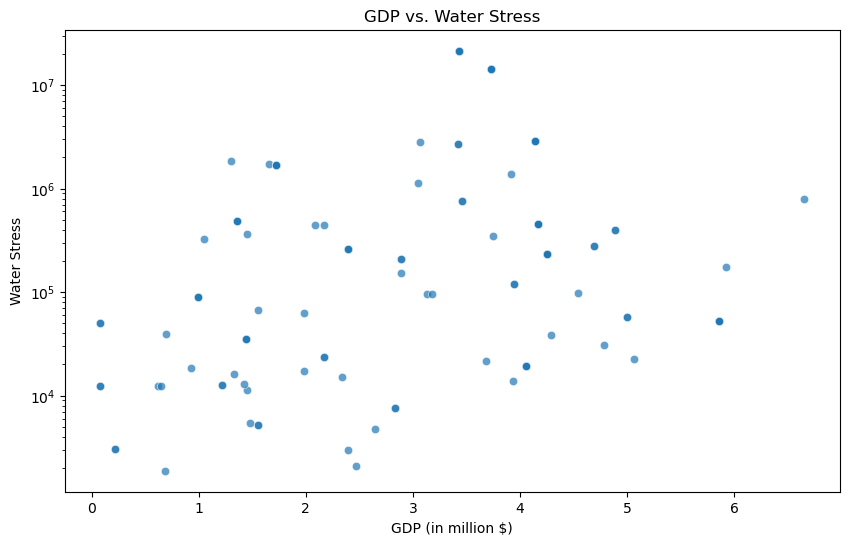

In [42]:
# Create a scatter plot of gdp versus water stress without a legend
plt.figure(figsize=(10, 6))

# Remove the legend
plt.legend([], [], frameon=False)

sns.scatterplot(data=merged, x='Log_Value', y='gdp_md_est', palette='viridis', alpha=0.7)
plt.title('GDP vs. Water Stress')
plt.xlabel('GDP (in million $)')
plt.ylabel('Water Stress')
plt.yscale('log')
plt.show()



C:\Users\Owner\AppData\Local\Temp\ipykernel_33028\3255305156.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=merged, x='Log_Value', y='fatalmax2', palette='viridis', alpha=0.7)


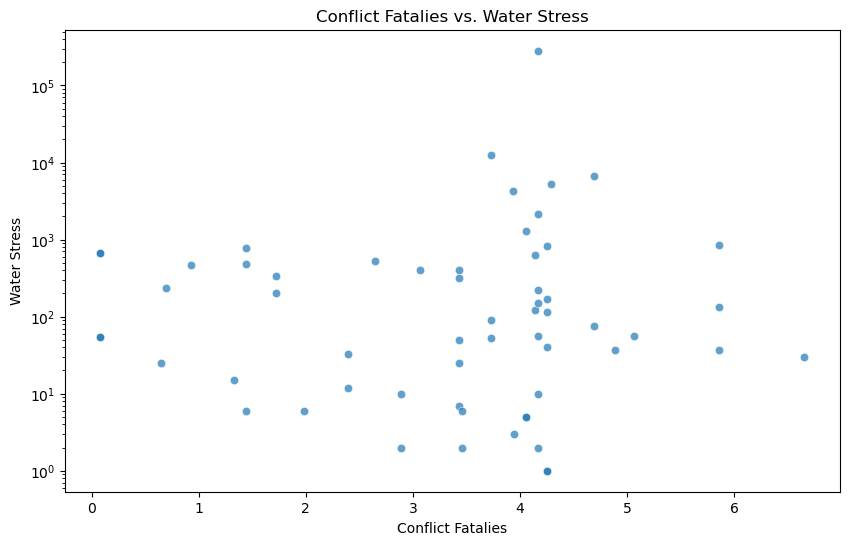

In [60]:
# Create a scatter plot of gdp versus water stress without a legend
plt.figure(figsize=(10, 6))

# Remove the legend
plt.legend([], [], frameon=False)

sns.scatterplot(data=merged, x='Log_Value', y='fatalmax2', palette='viridis', alpha=0.7)
plt.title('Conflict Fatalies vs. Water Stress')
plt.xlabel('Conflict Fatalies')
plt.ylabel('Water Stress')
plt.yscale('log')
plt.show()



In [64]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Categorize 'Log_Value' into bins
merged['Water_Stress_Category'] = pd.cut(merged['Log_Value'], bins=3, labels=['Low', 'Medium', 'High'])

# Display the first few rows to verify the categorization
print(merged[['Log_Value', 'Water_Stress_Category']].head())

# Conduct ANOVA using StatsModels
# Fit the OLS model
model = ols('gdp_md_est ~ C(Water_Stress_Category)', data=merged).fit()

# Get the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# The ANOVA test will tell you if there are statistically significant differences in GDP across the different levels of water stress, as defined by your bins.

   Log_Value Water_Stress_Category
0   1.982046                   Low
1   1.654801                   Low
2   3.433087                Medium
3   3.433087                Medium
4   3.433087                Medium
                                sum_sq     df          F    PR(>F)
C(Water_Stress_Category)  7.665491e+14    2.0  11.359714  0.000028
Residual                  4.521134e+15  134.0        NaN       NaN


In [44]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Categorize 'Log_Value' into bins
merged['Water_Stress_Category'] = pd.cut(merged['Log_Value'], bins=3, labels=['Low', 'Medium', 'High'])

# Display the first few rows to verify the categorization
print(merged[['Log_Value', 'Water_Stress_Category']].head())

# Conduct ANOVA using StatsModels
# Fit the OLS model
model = ols('gdp_md_est ~ C(Water_Stress_Category)', data=merged).fit()

# Get the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# The ANOVA test will tell you if there are statistically significant differences in GDP across the different levels of water stress, as defined by your bins.

   Log_Value Water_Stress_Category
0   1.982046                   Low
1   1.654801                   Low
2   3.433087                Medium
3   3.433087                Medium
4   3.433087                Medium
                                sum_sq     df          F    PR(>F)
C(Water_Stress_Category)  7.665491e+14    2.0  11.359714  0.000028
Residual                  4.521134e+15  134.0        NaN       NaN


In [1]:
# Categorize 'Log_Value' into bins
merged['Population_Category'] = pd.cut(merged['pop_est'], bins=3, labels=['Low', 'Medium', 'High'])

# Display the first few rows to verify the categorization
print(merged[['pop_est', 'Population_Category']].head())

# Conduct ANOVA using StatsModels
# Fit the OLS model
model = ols('Log_Value ~ C(Population_Category)', data=merged).fit()

# Get the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# The ANOVA test will tell you if there are statistically significant differences in GDP across the different levels of water stress, as defined by your bins.

NameError: name 'pd' is not defined

In [25]:
# Create a choropleth map
choropleth_map = merged.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='Log_Value',  # Column to color by
    cmap='OrRd',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Water Stress by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (Log_Value)

In [54]:
# Create a points layer using hvplot
points_layer = merged.hvplot.points(
    x = 'Targ_Country_Lng',
    y = 'Targ_Country_Lat',
    geo = True,
    tiles='OSM',  # Add a tile layer for context
    s ='fatalmax2',  # Size based on Event Count
    color= 'Target Country',  # Color of the points
    alpha=0.5,  # Transparency
    width=1920,
    height=1080,
    #hover_cols=['Conflict'],  # Columns to display on hover
    legend=False  # Disable legend for points
)

# Display map

points_layer

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [27]:
combined_map = choropleth_map * points_layer
combined_map = combined_map.opts(title='Water Stress and Conflict Fatalities by Country (1980-2014)')
combined_map

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (Log_Value)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [28]:
# Create a choropleth map
choropleth_map2 = world_normalized.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='pop_est',  # Column to color by
    cmap='YlGnBu',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Estimated Population by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map2

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)

In [29]:
combined_map2 = choropleth_map2 * points_layer
combined_map2 = combined_map2.opts(title='Estimated Population and Conflict Fatalities by Country')
combined_map2

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [30]:
# Create a points layer using hvplot
points_layer2 = merged.hvplot.points(
    x = 'Country_Lng',
    y = 'Country_Lat',
    geo = True,
    tiles='OSM',  # Add a tile layer for context
    s ='Value',  # Size based on Event Count
    color= 'Red',  # Color of the points
    alpha=0.5,  # Transparency
    width=1920,
    height=1080,
    #hover_cols=['Conflict'],  # Columns to display on hover
    legend=False  # Disable legend for points
)

# Display map

points_layer2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Country_Lng,Country_Lat]   (Value)

In [31]:
combined_map3 = choropleth_map2 * points_layer2
combined_map3 = combined_map3.opts(title='Estimated Population and Water Stress by Country')
combined_map3

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Country_Lng,Country_Lat]   (Value)

In [56]:
# Create a choropleth map
choropleth_map3 = world_normalized.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='gdp_md_est',  # Column to color by
    cmap='YlGn',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Gross Domestic Product by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map3

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (gdp_md_est)

In [57]:
combined_map4 = choropleth_map3 * points_layer2
combined_map4 = combined_map4.opts(title='Gross Domestic Product and Water Stress by Country')
combined_map4

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (gdp_md_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Country_Lng,Country_Lat]   (Value)